# What this note can do?

NOTE: we creaed original imput files by Extract_nongap-sites_on_HXB2_Rhesus_DNA.ipynb, which can be found at /Users/kais/Documents/CODE/HMMER_HIV/note/

- Table of index and mutation strength. 
- From this CSV file, determin Abs resitance mutation. 

In [8]:
#Pkg.add("Pkg"); import Pkg; 
using Pkg
using Distributed
using DelimitedFiles
using StatsBase
using Profile    
using Random
using Statistics
using LinearAlgebra
using Plots
using Printf
using Measures
using CSV
using LaTeXStrings;
using DataFrames
rng = Random.MersenneTwister(1234);

In [9]:
include("../src/basic_MPL.jl");
include("../src/basic.jl")
include("../src/my_HIV_data_cleanign.jl")
include("../src/basic_analysis.jl")
include("../src/analysis.jl")
include("../src/non_synonymous_N-glycan.jl") 
include("../src/process_HIV_mutation_for_CSV.jl") 
NUC = ["-", "A", "C", "G", "T"];

# Processes Start

## Retrieve variable and antibody binding sites 

In [10]:
# Keep trucking only the following sites and nucleotides;
# Should include also HXB2 inde for protein and genes. 
hxb2csv = DataFrame(CSV.File("../data/csv/hxb2.csv"));
csv_raw_CH103binding = DataFrame(CSV.File("../data/csv/CH103_binding.csv"))
csv_raw_CH235binding = DataFrame(CSV.File("../data/csv/CH235_binding.csv"))
csv_raw_CD4contact = DataFrame(CSV.File("../data/csv/CD4_contct_residue.csv"))
csv_raw_V1_HV = DataFrame(CSV.File("../data/csv/V1_Hypervariable_residue.csv"))
csv_raw_V2_HV = DataFrame(CSV.File("../data/csv/V2_Hypervariable_residue.csv"))
csv_raw_V3_HV = DataFrame(CSV.File("../data/csv/V3_Hypervariable_residue.csv"))
csv_raw_V4_HV = DataFrame(CSV.File("../data/csv/V4_Hypervariable_residue.csv"))
csv_raw_V5_HV = DataFrame(CSV.File("../data/csv/V5_Hypervariable_residue.csv"))
csv_raw_LoopD = DataFrame(CSV.File("../data/csv/Loop-D_residue.csv"));

csv_raw_resist_mut_CH103 = DataFrame(CSV.File("../data/csv/resistant_mut_to_CH103.csv")) 
csv_raw_resist_mut_CH235 = DataFrame(CSV.File("../data/csv/resistant_mut_to_CH235.csv")) 
csv_raw_resist_strain_specific_Abs_CH505 = DataFrame(CSV.File("../data/csv/resistant_mut_to_strain_specific-bnAbs_CH505.csv")) 
csv_raw_common_mut_SHIV_CH505 = DataFrame(CSV.File("../data/csv/common_mutation_rhesus_SHIV505.csv")) ;

## Formatting the files

In [11]:
csv_selection = DataFrame(CSV.File("../data/mpl/703010505-3-poly.csv"));

gene_set = [[] for _ in 1:3]; vec_AA_idx = [[] for _ in 1:3]; HXB2_set = [[] for _ in 1:3]; 
vec_nuc_idx = []; frame_set = []; 
for x in csv_selection.HXB2_index
    num_nuc = get_num_nuc(x)
    frame, gene = index2frame(num_nuc)
    num_nuc, num_AA, gene = map_numNUC_to_numAA(x, frame)
    #@assert(gene==gene_check)
    
    push!(frame_set, frame)
    push!(vec_nuc_idx, num_nuc)
    for fr in 1:3 
        push!(gene_set[fr], gene[fr])
        push!(vec_AA_idx[fr], num_AA[fr])
        push!(HXB2_set[fr], HXB2(num_nuc, num_AA[fr], gene[fr]))
    end
end;

@printf("Fr.1: gene: %s\n", join(unique(gene_set[1]), ", "));
@printf("Fr.2: gene: %s\n", join(unique(gene_set[2]), ", "));
@printf("Fr.3: gene: %s\n", join(unique(gene_set[3]), ", "));
@printf("max: %d, %d\n", maximum(skipmissing(vec_nuc_idx)), maximum(skipmissing(vec_nuc_idx))) 
@printf("min: %d, %d\n", minimum(skipmissing(vec_nuc_idx)), minimum(skipmissing(vec_nuc_idx)));

# Use frame 3 where Env gene belongs. 
vec_CH103_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH103binding)
vec_CH235_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH235binding)
vec_CD4contact_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CD4contact)
vec_V1 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V1_HV)
vec_V2 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V2_HV)
vec_V3 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V3_HV)
vec_V4 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V4_HV)
vec_V5 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V5_HV)
vec_LoopD = get_true_false_variable_region(vec_AA_idx[3], csv_raw_LoopD);

# These are all waat I need. 
csv_index_and_TF= DataFrame(CSV.File("../data/mpl/703010505-3-index.csv"));
seq_num_raw = readdlm("../data/mpl/703010505-3-poly-seq2state.dat", Int);

Fr.1: gene: , tat
Fr.2: gene: vpu, , rev
Fr.3: gene: env
max: 8795, 8795
min: 6225, 6225


## Processes to get mutations 

In [12]:
# ---- Get mutations ------#
(mutant_hxb2, mutant_nuc, mutant_date_found, mutant_gene, mutant_types_set_AA, 
mutant_types_set_nuc, mutant_types_set_nuc_simple, plus_glycan_set, minus_glycan_set, shifted_glycan_set
) = Make_combination_of_mutations_with_genetic_background_w_glycan(csv_index_and_TF, seq_num_raw, hxb2csv); 
mutant_types_set_AA_filtered = []
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[1]));
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[2]));
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[3]));


mutant_types_set_TF_AA = get_TF_AA(csv_index_and_TF, mutant_hxb2) ;
mutant_types_set_AA_filtered_v2 = []
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[1], mutant_types_set_TF_AA[1]))
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[2], mutant_types_set_TF_AA[2]))
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[3], mutant_types_set_TF_AA[3]));


## Check the entories of resistant mutations

In [13]:
# Check the ordering is the same as the *-3-poly and *-3-index. 
for i in 1:length(csv_selection.HXB2_index)
    i_HXB2 = csv_selection.HXB2_index[i]
    i_HXB2_v2 = mutant_hxb2[i]
    nuc = csv_selection.nucleotide[i]
    nuc_v2 = mutant_nuc[i]
    @assert (i_HXB2 == i_HXB2_v2 && nuc == nuc_v2)
end

# --- Check whether mutations have been reported or not. ---# 
reported_mutant_data = copy(String.(csv_raw_resist_mut_CH103[:, 1]))
bool_resist_mut_CH103 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_resist_mut_CH235[:, 1]))
bool_resist_mut_CH235 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_resist_strain_specific_Abs_CH505[:, 1]))
bool_resist_strain_specific_Abs_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_common_mut_SHIV_CH505[:, 1]))
bool_common_mut_SHIV_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
reversion_true_false = csv_selection.consensus.== csv_selection.nucleotide .!= csv_selection.TF;

In [14]:
# --- Just filling basic information ----#
idx_sort_MPL = sortperm(csv_selection.s_MPL, rev=true);
idx = (mutant_types_set_nuc[3][idx_sort_MPL] .!= "") .* (mutant_date_found[idx_sort_MPL] .> 0)
df = DataFrame( HXB2=vec_nuc_idx[idx_sort_MPL][idx], )

df[!, "i_AA_fr1"]=replace_nothing_with_missing(vec_AA_idx[1])[idx_sort_MPL][idx]
df[!, "i_AA_fr2"]=replace_nothing_with_missing(vec_AA_idx[2])[idx_sort_MPL][idx]
df[!, "i_AA_fr3"]=replace_nothing_with_missing(vec_AA_idx[3])[idx_sort_MPL][idx]
df[!, "gene_fr1"]=replace_nothing_with_missing(gene_set[1])[idx_sort_MPL][idx]
df[!, "gene_fr2"]=replace_nothing_with_missing(gene_set[2])[idx_sort_MPL][idx]
df[!, "gene_fr3"]=replace_nothing_with_missing(gene_set[3])[idx_sort_MPL][idx]

# -- Just copying fields already in the *-3-poly.csv
for header_temp in names(csv_selection)
    if(!occursin(r"f_at", header_temp) && !occursin(r"epitope", header_temp))
        df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
    end
end
# --- Writing computed variables including types of mutaions ----#
df[!, "detected_date"] = mutant_date_found[idx_sort_MPL][idx]
df[!, "mutants_nuc"] = mutant_types_set_nuc_simple[3][idx_sort_MPL][idx]

df[!, "mutants_AA_fr1"] = mutant_types_set_AA_filtered_v2[1][idx_sort_MPL][idx]
df[!, "mutants_AA_fr2"] = mutant_types_set_AA_filtered_v2[2][idx_sort_MPL][idx]
df[!, "mutants_AA_fr3"] = mutant_types_set_AA_filtered_v2[3][idx_sort_MPL][idx]
df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr1"] = plus_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr1"] = minus_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr1"] = shifted_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr2"] = plus_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr2"] = minus_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr2"] = shifted_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr3"] = plus_glycan_set[3][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr3"] = minus_glycan_set[3][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr3"] = shifted_glycan_set[3][idx_sort_MPL][idx]

# -- Just copying single site trajectories *-3-poly.csv
for header_temp in names(csv_selection)
    if(occursin(r"f_at", header_temp) )
        df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
    end
end
CSV.write("../out/703010505-3-poly_sorted_with_mutant.csv", df); 

# CSV files for Rhesus Macaques

In [15]:
fname_key_RMs = ["RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];

In [16]:
for key_RM in fname_key_RMs
    @sprintf("%s\n", key_RM)
    csv_selection = DataFrame(CSV.File("../data/mpl/SHIV.CH505/" * key_RM * "-3-poly.csv"));

    gene_set = [[] for _ in 1:3]; vec_AA_idx = [[] for _ in 1:3]; HXB2_set = [[] for _ in 1:3]; 
    vec_nuc_idx = []; frame_set = []; 
    for x in csv_selection.HXB2_index
        num_nuc = get_num_nuc(x)
        frame, gene = index2frame(num_nuc)
        num_nuc, num_AA, gene = map_numNUC_to_numAA(x, frame)
        #@assert(gene==gene_check)

        push!(frame_set, frame)
        push!(vec_nuc_idx, num_nuc)
        for fr in 1:3 
            push!(gene_set[fr], gene[fr])
            push!(vec_AA_idx[fr], num_AA[fr])
            push!(HXB2_set[fr], HXB2(num_nuc, num_AA[fr], gene[fr]))
        end
    end;
    """
    @printf("Fr.1: gene: %s\n", join(unique(gene_set[1]), ", "));
    @printf("Fr.2: gene: %s\n", join(unique(gene_set[2]), ", "));
    @printf("Fr.3: gene: %s\n", join(unique(gene_set[3]), ", "));
    @printf("max: %d, %d\n", maximum(skipmissing(vec_nuc_idx)), maximum(skipmissing(vec_nuc_idx))) 
    @printf("min: %d, %d\n", minimum(skipmissing(vec_nuc_idx)), minimum(skipmissing(vec_nuc_idx)));
    """

    # Use frame 3 where Env gene belongs. 
    vec_CH103_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH103binding)
    vec_CH235_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH235binding)
    vec_CD4contact_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CD4contact)
    vec_V1 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V1_HV)
    vec_V2 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V2_HV)
    vec_V3 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V3_HV)
    vec_V4 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V4_HV)
    vec_V5 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V5_HV)
    vec_LoopD = get_true_false_variable_region(vec_AA_idx[3], csv_raw_LoopD);
    # ----------------------------------------------------------------#

    # These are all waat I need. 
    csv_index_and_TF= DataFrame(CSV.File("../data/mpl/SHIV.CH505/" *key_RM* "-3-index.csv"));
    seq_num_raw = readdlm("../data/mpl/SHIV.CH505/" *key_RM* "-3-poly-seq2state.dat", Int);

    # ---- Get mutations ------#
    (mutant_hxb2, mutant_nuc, mutant_date_found, mutant_gene, mutant_types_set_AA, 
    mutant_types_set_nuc, mutant_types_set_nuc_simple, plus_glycan_set, minus_glycan_set, shifted_glycan_set
    ) = Make_combination_of_mutations_with_genetic_background_w_glycan(csv_index_and_TF, seq_num_raw, hxb2csv); 
    mutant_types_set_AA_filtered = []
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[1]));
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[2]));
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[3]));

    # ----------------------------------------------------------------#
    for i in 1:length(csv_selection.HXB2_index)
        i_HXB2 = csv_selection.HXB2_index[i]
        i_HXB2_v2 = mutant_hxb2[i]
        nuc = csv_selection.nucleotide[i]
        nuc_v2 = mutant_nuc[i]
    end

    # --- Check whether mutations have been reported or not. ---# 
    reported_mutant_data = copy(String.(csv_raw_resist_mut_CH103[:, 1]))
    bool_resist_mut_CH103 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_resist_mut_CH235[:, 1]))
    bool_resist_mut_CH235 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_resist_strain_specific_Abs_CH505[:, 1]))
    bool_resist_strain_specific_Abs_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_common_mut_SHIV_CH505[:, 1]))
    bool_common_mut_SHIV_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
    reversion_true_false = csv_selection.consensus .== csv_selection.nucleotide .!= csv_selection.TF;
    
    # --- Just filling basic information ----#
    idx_sort_MPL = sortperm(csv_selection.s_MPL, rev=true);
    idx = (mutant_types_set_nuc[3][idx_sort_MPL] .!= "") .* (mutant_date_found[idx_sort_MPL] .> 0)
    df = DataFrame(HXB2=vec_nuc_idx[idx_sort_MPL][idx], )
    
    df[!, "i_AA_fr1"]=replace_nothing_with_missing(vec_AA_idx[1])[idx_sort_MPL][idx]
    df[!, "i_AA_fr2"]=replace_nothing_with_missing(vec_AA_idx[2])[idx_sort_MPL][idx]
    df[!, "i_AA_fr3"]=replace_nothing_with_missing(vec_AA_idx[3])[idx_sort_MPL][idx]
    df[!, "gene_fr1"]=replace_nothing_with_missing(gene_set[1])[idx_sort_MPL][idx]
    df[!, "gene_fr2"]=replace_nothing_with_missing(gene_set[2])[idx_sort_MPL][idx]
    df[!, "gene_fr3"]=replace_nothing_with_missing(gene_set[3])[idx_sort_MPL][idx]

    # -- Just copying fields already in the *-3-poly.csv
    for header_temp in names(csv_selection)
        if(!occursin(r"f_at", header_temp) && !occursin(r"epitope", header_temp))
            df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
        end
    end

    # --- Writing computed variables including types of mutaions ----#
    df[!, "detected_date"] = mutant_date_found[idx_sort_MPL][idx]
    df[!, "mutants_nuc_filtered"] = mutant_types_set_nuc_simple[3][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr1"] = mutant_types_set_AA_filtered[1][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr2"] = mutant_types_set_AA_filtered[2][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr3"] = mutant_types_set_AA_filtered[3][idx_sort_MPL][idx]
    df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
    df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
    df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
    df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
    df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
    df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
    df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
    df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
    df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
    df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
    df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
    df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
    df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
    df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr1"] = plus_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr1"] = minus_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr1"] = shifted_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr2"] = plus_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr2"] = minus_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr2"] = shifted_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr3"] = plus_glycan_set[3][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr3"] = minus_glycan_set[3][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr3"] = shifted_glycan_set[3][idx_sort_MPL][idx]
    
    # -- Just copying single site trajectories *-3-poly.csv
    for header_temp in names(csv_selection)
        if(occursin(r"f_at", header_temp) )
            df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
        end
    end

    CSV.write("../out/" *key_RM* "-3-poly_sorted_with_mutant.csv", df);
end

# Processes for Jointed Rhessu

In [17]:
f_dir = "../data/mpl/SHIV.CH505/"
csv_index_and_TF = DataFrame(CSV.File(f_dir * "Marged-RMs-index_with_poly_idx.csv"));
s_MPL_RMs = readdlm(f_dir * "RMs-poly-seq2state-MPL.dat")
s_SL_RMs = readdlm(f_dir * "RMs-poly-seq2state-SL.dat");
dx_RMs = readdlm(f_dir * "numerator-RMs-3-poly-seq2state.dat");
fname_key_RMs_and_Human = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];
n_max_RMs = length(fname_key_RMs_and_Human);

## Get processed mutations for jointed RMs for CSV file 
(polymorphic_index_global, HXB2_index_global, nucleotide_global, 
    TF_global, TF_global_RMs, nonsynonymous_global, nonsynonymous_global_RMs, 
    edge_gap_global, edge_gap_global_RMs, exposed_global, exposed_global_RMs, 
    flanking_global, flanking_global_RMs, glycan_global, glycan_global_RMs, consensus_global, consensus_global_RMs, 
    dx_marginalized, s_MPL_marginalized, s_SL_marginalized, s_MPL_global, s_SL_global) = get_csv_RMs(
    f_dir, csv_index_and_TF, s_MPL_RMs, s_SL_RMs, dx_RMs, fname_key_RMs_and_Human);

In [18]:
df = DataFrame( 
    polymorphic=polymorphic_index_global, 
    HXB2=HXB2_index_global, 
    nuc=nucleotide_global, 
    TF=TF_global, 
    TF_RMs=TF_global_RMs,
    nonsynonymous=nonsynonymous_global, 
    nonsynonymous_RMs=nonsynonymous_global_RMs, 
    consensus=consensus_global, 
    consensus_RMs=consensus_global_RMs,
    edge_gap=edge_gap_global, 
    edge_gap_RMs=edge_gap_global_RMs, 
    exposed=exposed_global, 
    exposed_RMs=exposed_global_RMs, 
    flanking=flanking_global, 
    flanking_RMs=flanking_global_RMs, 
    glycan=glycan_global, 
    glycan_RMs=glycan_global_RMs,  
)

df[:, "dx_RMs"] = dx_marginalized
df[:, "s_MPL_RMs"] = s_MPL_marginalized
for k in 1:n_max_RMs
    df[:, "s_MPL_"*fname_key_RMs_and_Human[k]] = s_MPL_global[k]
end
df[:, "s_SL_RMs"] = s_SL_marginalized
for k in 1:n_max_RMs
    df[:, "s_SL_"*fname_key_RMs_and_Human[k]] = s_SL_global[k]
end
CSV.write("../out/Marged-RMs-3-poly_SHIVCH505.csv", df);

## Normalizing selection coefficients 

In [19]:
csv_in = DataFrame(CSV.File("../out/Marged-RMs-3-poly_SHIVCH505.csv"));

polymorphic_unique = sort(unique(csv_in.polymorphic))
poly_max = maximum(polymorphic_unique)+1
s_mpl_TF = [0.0 for _ in 1:poly_max]
s_sl_TF = [0.0 for _ in 1:poly_max]
NA_list = [false for _ in 1:poly_max]
for x in polymorphic_unique
    tf_in = custom_mode(csv_in.TF_RMs[csv_in.polymorphic .== x])
    if(tf_in != "NA")
        idx1 = csv_in.polymorphic .== x
        idx2 = csv_in.nuc .== tf_in
        idx = idx1 .* idx2
        s_mpl_TF[x+1] = csv_in.s_MPL_RMs[idx][1]
        s_sl_TF[x+1] = csv_in.s_SL_RMs[idx][1]
        NA_list[x+1] = true
    end
end;

s_MPL_norm = []; s_SL_norm = []
for i in 1:length(csv_in.polymorphic)
    if( NA_list[ csv_in.polymorphic[i] + 1 ] )
        s_mpl_temp = csv_in.s_MPL_RMs[i] - s_mpl_TF[ csv_in.polymorphic[i] + 1 ]
        s_sl_temp = csv_in.s_SL_RMs[i] - s_sl_TF[ csv_in.polymorphic[i] + 1 ]
        push!(s_MPL_norm, s_mpl_temp)
        push!(s_SL_norm, s_sl_temp)
    else
        push!(s_MPL_norm, "NA")
        push!(s_SL_norm, "NA")
    end
end;

In [20]:
idx_non_NA = csv_in.TF_RMs .!= "NA"
df = DataFrame( 
    polymorphic=csv_in.polymorphic[idx_non_NA], 
    HXB2=csv_in.HXB2[idx_non_NA], 
    nuc=csv_in.nuc[idx_non_NA], 
    TF=csv_in.TF[idx_non_NA], 
    TF_RMs=csv_in.TF_RMs[idx_non_NA],
    nonsynonymous=csv_in.nonsynonymous[idx_non_NA], 
    nonsynonymous_RMs=csv_in.nonsynonymous_RMs[idx_non_NA], 
    consensus=csv_in.consensus[idx_non_NA], 
    consensus_RMs=csv_in.consensus_RMs[idx_non_NA],
    edge_gap=csv_in.edge_gap[idx_non_NA], 
    edge_gap_RMs=csv_in.edge_gap_RMs[idx_non_NA], 
    exposed=csv_in.exposed[idx_non_NA], 
    exposed_RMs=csv_in.exposed_RMs[idx_non_NA], 
    flanking=csv_in.flanking[idx_non_NA], 
    flanking_RMs=csv_in.flanking_RMs[idx_non_NA], 
    glycan=csv_in.glycan[idx_non_NA], 
    glycan_RMs=csv_in.glycan_RMs[idx_non_NA],  
)

df[:, "dx_RMs"] = csv_in.dx_RMs[idx_non_NA]
df[:, "s_MPL_RMs"] = s_MPL_norm[idx_non_NA]
for k in 1:n_max_RMs
    df[:, "s_MPL_"*fname_key_RMs_and_Human[k]] = csv_in[idx_non_NA, Symbol("s_MPL_"*fname_key_RMs_and_Human[k])]
end
df[:, "s_SL_RMs"] = s_SL_norm[idx_non_NA]
for k in 1:n_max_RMs
    df[:, "s_SL_"*fname_key_RMs_and_Human[k]] = csv_in[idx_non_NA, Symbol("s_SL_"*fname_key_RMs_and_Human[k])]
end
CSV.write("../out/Marged-RMs-normalized-3-poly_SHIVCH505.csv", df);



# Making CSV file containing mutations for marginalized RMs.  

Note: this process consider only Env gene;

In [21]:
csv_selection = DataFrame(CSV.File("../out/Marged-RMs-normalized-3-poly_SHIVCH505.csv"));
csv_index_and_TF= DataFrame(CSV.File("../data/mpl/SHIV.CH505/Marged-RMs-index_with_poly_idx.csv"));

In [22]:
(vec_gene_idx, vec_nuc_idx, vec_AA_idx, vec_TF, 
    vec_CH103_binding, vec_CH235_binding, vec_CD4contact_binding, 
    vec_V1, vec_V2, vec_V3, vec_V4, vec_V5, vec_LoopD, 
    mutant_types_set_nuc_simple, mutant_types_set_AA_filtered, 
    Nlinked_plus_set, Nlinked_minus_set, Nlinked_shift_set,
    bool_resist_mut_CH103, bool_resist_mut_CH235, bool_resist_strain_specific_Abs_CH505, 
    bool_common_mut_SHIV_CH505, reversion_true_false) = get_jointed_RMs_for_CSV(
    csv_selection, csv_index_and_TF, fname_key_RMs_and_Human, fname_key_RMs);

gene: env
max: 8347, 8347
min: 6228, 6228
Processing 703010505, done.
Processing RM5695, done.
Processing RM6072, done.
Processing RM6701, done.
Processing RM6699, done.
Processing RM6697, done.
Processing RM6070, done.
Processing RM6703, done.


In [23]:
# --- Just filling basic information ----#
idx_sort_MPL = sortperm(csv_selection.s_MPL_RMs, rev=true);
idx = mutant_types_set_nuc_simple[idx_sort_MPL] .!= ""
df = DataFrame(
    HXB2=vec_nuc_idx[idx_sort_MPL][idx], 
    AA_idx=replace_nothing_with_missing(vec_AA_idx)[idx_sort_MPL][idx],
    gene=replace_nothing_with_missing(vec_gene_idx)[idx_sort_MPL][idx]
)
df[!, "mutants_nuc"] = mutant_types_set_nuc_simple[idx_sort_MPL][idx]
df[!, "mutants_AA"] = mutant_types_set_AA_filtered[idx_sort_MPL][idx]
# -- Just copying fields already in the *-3-poly.csv
for header_temp in names(csv_selection)
    df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
end
for k in 1:length(fname_key_RMs_and_Human)
    df[:, "N_plus_"*fname_key_RMs_and_Human[k]] = Nlinked_plus_set[k][idx_sort_MPL][idx]
    df[:, "N_minus_"*fname_key_RMs_and_Human[k]] = Nlinked_minus_set[k][idx_sort_MPL][idx]
    df[:, "N_shift_"*fname_key_RMs_and_Human[k]] = Nlinked_shift_set[k][idx_sort_MPL][idx]
end

# --- Writing computed variables including types of mutaions ----#
df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx];
CSV.write("../out/RMs-merged-3-poly_sorted_with_mutant_CH505.csv", df);

## Enrichment  -> CSV 

In [24]:
#"""
csv_index_and_TF= DataFrame(CSV.File("../data/mpl/703010505-3-index.csv"));
seq_num_raw = readdlm("../data/mpl/703010505-3-poly-seq2state.dat", Int);
csv_raw_CH505 = DataFrame(CSV.File("../out/703010505-3-poly_sorted_with_mutant.csv"));
#csv_raw_C505 = DataFrame(CSV.File("/net/dali/home/barton/kais/HIV_coevolution_analysis/out/redo_on_cluster/CSV/CH505/703010505-3-poly_sorted_with_mutant.csv"));
categories = ["Rev.", "V1", "V2", "V3", "V4", "V5", "LD", "CD4", "PNG-shield", "PNG-holse", "PNG-shift"];

s_threshold_RMs_set = collect(-0.04:0.005:0.04)
#x_fold_reversion_set = []
x_fold_V1_set = []; n_fold_V1_set = []
x_fold_V2_set = []; n_fold_V2_set = []
x_fold_V3_set = []; n_fold_V3_set = []
x_fold_V4_set = []; n_fold_V4_set = []
x_fold_V5_set = []; n_fold_V5_set = []
x_fold_reversion_set = []; n_fold_reversion_set = []
x_fold_LoopD_set = []; n_fold_LoopD_set = []
x_fold_CD4BS_set = []; n_fold_CD4BS_set = []
x_fold_N_rem_set = []; n_fold_N_rem_set = []
x_fold_N_add_set = []; n_fold_N_add_set = []
x_fold_N_sht_set = []; n_fold_N_sht_set = []
α_selected_est = []
for s_threshold_RMs in s_threshold_RMs_set
    idx_significant = csv_raw_CH505.s_MPL .>= s_threshold_RMs;
    len_tot_entries = length(csv_raw_CH505.HXB2_index)
    len_selected = count(idx_significant)
    α_selected = len_selected / len_tot_entries;
    
    idx_type = copy(idx_HXB2_LD)
    idx_type_in = copy(csv_raw_CH505.LoopD)
    (N_sel_LD, n_sel_LD) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    (N_null, n_null_LD) = get_num_of_nonsyn(csv_index_and_TF, idx_type)
    N_null = n_null_LD; n_null_LD *= α_selected
    (n_subjected_LoopD, n_estimated_LoopD, n_tot_LoopD, x_fold_LoopD) = get_x_fold(n_sel_LD, N_sel_LD, n_null_LD, N_null)
    
    idx_type = copy(idx_HXB2_CD4BS)
    idx_type_in = copy(csv_raw_CH505.CD4BS)
    (N_sel_CD4BS, n_sel_CD4BS) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    (N_null, n_null_CD4BS) = get_num_of_nonsyn(csv_index_and_TF, idx_type)
    N_null = n_null_CD4BS; n_null_CD4BS *= α_selected
    (n_subjected_CD4BS, n_estimated_CD4BS, n_tot_CD4BS, x_fold_CD4BS) = get_x_fold(n_sel_CD4BS, N_sel_CD4BS, n_null_CD4BS, N_null)

    idx_type = copy(idx_HXB2_V1)
    idx_type_in = copy(csv_raw_CH505.V1)
    (N_sel_V1, n_sel_V1) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    (N_null, n_null_V1) = get_num_of_nonsyn(csv_index_and_TF, idx_type)
    N_null = n_null_V1; n_null_V1 *= α_selected
    (n_subjected_V1, n_estimated_V1, n_tot_V1, x_fold_V1) = get_x_fold(n_sel_V1, N_sel_V1, n_null_V1, N_null)

    idx_type = copy(idx_HXB2_V2)
    idx_type_in = copy(csv_raw_CH505.V2)
    (N_sel_V2, n_sel_V2) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    (N_null, n_null_V2) = get_num_of_nonsyn(csv_index_and_TF, idx_type)
    N_null = n_null_V2; n_null_V2 *= α_selected
    (n_subjected_V2, n_estimatd_V2, n_tot_V2, x_fold_V2) = get_x_fold(n_sel_V2, N_sel_V2, n_null_V2, N_null)

    idx_type = copy(idx_HXB2_V3)
    idx_type_in = copy(csv_raw_CH505.V3)
    (N_sel_V3, n_sel_V3) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    (N_null, n_null_V3) = get_num_of_nonsyn(csv_index_and_TF, idx_type)
    N_null = n_null_V3; n_null_V3 *= α_selected
    (n_subjected_V3, n_estimated_V3, n_tot_V3, x_fold_V3) = get_x_fold(n_sel_V3, N_sel_V3, n_null_V3, N_null)

    idx_type = copy(idx_HXB2_V4)
    idx_type_in = copy(csv_raw_CH505.V4)
    (N_sel_V4, n_sel_V4) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    (N_null, n_null_V4) = get_num_of_nonsyn(csv_index_and_TF, idx_type)
    N_null = n_null_V4; n_null_V4 *= α_selected
    (n_subjected_V4, n_estimated_V4, n_tot_V4, x_fold_V4) = get_x_fold(n_sel_V4, N_sel_V4, n_null_V4, N_null)

    idx_type = copy(idx_HXB2_V5)
    idx_type_in = copy(csv_raw_CH505.V5)
    (N_sel_V5, n_sel_V5) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    (N_null, n_null_V5) = get_num_of_nonsyn(csv_index_and_TF, idx_type)
    N_null = n_null_V5; n_null_V5 *= α_selected
    (n_subjected_V5, n_estimated_V5, n_tot_V5, x_fold_V5) = get_x_fold(n_sel_V5, N_sel_V5, n_null_V5, N_null)

    #  ------------ Reversion Mutations -------------  #
    #N_null = length(csv_index_and_TF[csv_index_and_TF.TF .!= "-", 1]) * 3
    #n_null = count(  (csv_index_and_TF.consensus .!= csv_index_and_TF.TF)[csv_index_and_TF.TF .!= "-", 1]);
    (N_sel_rev, n_sel_rev) = get_n_sel_and_N_sel_reversion(csv_raw_CH505, csv_index_and_TF, idx_significant)
    (N_null, n_null_rev) = get_num_of_nonsyn_reversion(csv_index_and_TF)
    N_null = n_null_rev; n_null_rev *= α_selected
    (n_subjected_reversion, n_estimated_reversion, n_tot_reversion, x_fold_reversion) = get_x_fold(n_sel_rev, N_sel_rev, n_null_rev, N_null)

    #  ------------ Glycan Mutations -------------  #
    idx_N_add = csv_raw_CH505.N_linked_glycan_plus_fr3 .> 0
    idx_N_rem = csv_raw_CH505.N_linked_glycan_minus_fr3 .> 0
    idx_N_sht = csv_raw_CH505.N_linked_glycan_shift_fr3 .> 0
    (N_non_syn, n_null_N_add, n_null_N_rem, n_null_N_sht) = get_glycan_plus_minus_shift_statistics(csv_index_and_TF);
    N_null_add = n_null_N_add; N_null_rem = n_null_N_rem; N_null_sht = n_null_N_sht
    n_null_N_add *= α_selected; n_null_N_rem *= α_selected; n_null_N_sht *= α_selected
    #
    idx_type = copy(idx_N_add)
    idx_type_in = copy(csv_raw_CH505.N_linked_glycan_plus_fr3 .> 0 )
    (N_add_sel, n_add_sel) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    #
    idx_type = copy(idx_N_rem)
    idx_type_in = copy(csv_raw_CH505.N_linked_glycan_minus_fr3 .> 0 )
    (N_rem_sel, n_rem_sel) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)
    #
    idx_type = copy(idx_N_sht)
    idx_type_in = copy(csv_raw_CH505.N_linked_glycan_shift_fr3 .> 0 )
    (N_sht_sel, n_sht_sel) = get_n_sel_and_N_sel(idx_type_in, csv_raw_CH505, csv_index_and_TF, idx_significant)


    (n_subjected_N_add, n_estimated_N_add, n_tot_N_add, x_fold_N_add) = get_x_fold(n_add_sel, N_add_sel, n_null_N_add, N_null_add)
    (n_subjected_N_rem, n_estimated_N_rem, n_tot_N_rem, x_fold_N_rem) = get_x_fold(n_rem_sel, N_rem_sel, n_null_N_rem, N_null_rem)
    (n_subjected_N_sht, n_estimated_N_sht, n_tot_N_sht, x_fold_N_sht) = get_x_fold(n_sht_sel, N_sht_sel, n_null_N_sht, N_null_sht)
    # --------------------------------------------------------------- #     
#    @printf("α:%.2f: LD:%.1f(%d,%d) CD4BS:%.1f(%d,%d) rev:%.1f(%d,%d)\n", 
#            100*α_selected, x_fold_LoopD, n_sel_LD, n_null_LD, x_fold_CD4BS, n_sel_CD4BS, n_null_CD4BS, x_fold_reversion, n_sel_rev, n_null_rev)

    @printf("α:%.2f: V1:%.1f(%d,%d) V2:%.1f(%d,%d) V3:%.1f(%d,%d) V4:%.1f(%d,%d) V5:%.1f(%d,%d)\n", 
            100*α_selected, x_fold_V1, n_sel_V1, n_null_V1, x_fold_V2, n_sel_V2, n_null_V2, x_fold_V3, n_sel_V3, n_null_V3, x_fold_V4, n_sel_V4, n_null_V4, x_fold_V5, n_sel_V5, n_null_V5)

#    @printf("α:%.2f: N+:%.1f(%d,%d) N-:%.1f(%d,%d) N±:%.1f(%d,%d)\n",
#            100*α_selected, x_fold_N_add, n_sel_N_add, n_null_N_add, x_fold_N_rem, n_sel_N_rem, n_null_N_rem, x_fold_N_sht, n_sel_N_sht, n_null_N_sht)
    
    push!(x_fold_LoopD_set, x_fold_LoopD); push!(n_fold_LoopD_set, n_subjected_LoopD)
    push!(x_fold_CD4BS_set, x_fold_CD4BS); push!(n_fold_CD4BS_set, n_subjected_CD4BS)   
    push!(x_fold_V1_set, x_fold_V1); push!(n_fold_V1_set, n_subjected_V1)
    push!(x_fold_V2_set, x_fold_V2); push!(n_fold_V2_set, n_subjected_V2)
    push!(x_fold_V3_set, x_fold_V3); push!(n_fold_V3_set, n_subjected_V3)
    push!(x_fold_V4_set, x_fold_V4); push!(n_fold_V4_set, n_subjected_V4)
    push!(x_fold_V5_set, x_fold_V5); push!(n_fold_V5_set, n_subjected_V5)

    push!(x_fold_reversion_set, x_fold_reversion); push!(n_fold_reversion_set, n_subjected_reversion)
    push!(x_fold_N_rem_set, x_fold_N_rem); push!(n_fold_N_rem_set, n_subjected_N_rem)
    push!(x_fold_N_add_set, x_fold_N_add); push!(n_fold_N_add_set, n_subjected_N_add)
    push!(x_fold_N_sht_set, x_fold_N_sht); push!(n_fold_N_sht_set, n_subjected_N_sht)
    
    push!(α_selected_est, α_selected)
end


(aa_MT, aa_TF) = (Any["-", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["L", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["V", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["L", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["-", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["K", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["T", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["R", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["-", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["I", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["I", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["I", "R", "V"], Any["M", "R", "V"])
(aa_MT, aa_TF) = (Any["M", "-", "V", "M"], Any["M", "R", "V", "M"])
(aa_MT, aa_TF) = (Any["M", "G", "V", "M"], Any["M", "R", "V", "M"])
(aa_MT, aa_TF) = (Any["M", "*", "V", "M"], Any["M", "R", "V", "M"])
(aa_MT, aa_TF) = (Any["M", "-", "V", "M"], Any["M", "R", "V", "M"])
(aa_MT, aa_TF) = (Any["M", "K", 

(aa_MT, aa_TF) = (Any["P", "Q", "C", "W", "-"], Any["P", "Q", "W", "W", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "-", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "R", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "R", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "G", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "-", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "*", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "S", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "L", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "-", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "*", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "C", "-", "-"], Any["Q", "W", "W", "-", "-"])
(aa_MT, aa_TF) = (Any["Q", "W", "C", "-", "-"], Any["Q", "W", "W

(aa_MT, aa_TF) = (Any["L", "M", "-", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "L", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "V", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "F", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "-", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "N", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "T", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "S", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "-", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["L", "M", "M", "C", "N"], Any["L", "M", "I", "C", "N"])
(aa_MT, aa_TF) = (Any["M", "I", "-", "N", "G"], Any["M", "I", "C", "N", "G"])
(aa_MT, aa_TF) = (Any["M", "I", "S", "N", "G"], Any["M", "I", "C", "N", "G"])
(aa_MT, aa_TF) = (Any["M", "I", "R", "N", "G"], Any["M", "I", "C

(aa_MT, aa_TF) = (Any["G", "V", "-", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["G", "V", "T", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["G", "V", "A", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["G", "V", "S", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["G", "V", "-", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["G", "V", "H", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["G", "V", "R", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["G", "V", "L", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["G", "V", "-", "V", "W"], Any["G", "V", "P", "V", "W"])
(aa_MT, aa_TF) = (Any["V", "P", "-", "W", "K"], Any["V", "P", "V", "W", "K"])
(aa_MT, aa_TF) = (Any["V", "P", "M", "W", "K"], Any["V", "P", "V", "W", "K"])
(aa_MT, aa_TF) = (Any["V", "P", "L", "W", "K"], Any["V", "P", "V", "W", "K"])
(aa_MT, aa_TF) = (Any["V", "P", "L", "W", "K"], Any["V", "P", "V

(aa_MT, aa_TF) = (Any["C", "A", "A", "D", "A"], Any["C", "A", "S", "D", "A"])
(aa_MT, aa_TF) = (Any["C", "A", "-", "D", "A"], Any["C", "A", "S", "D", "A"])
(aa_MT, aa_TF) = (Any["C", "A", "*", "D", "A"], Any["C", "A", "S", "D", "A"])
(aa_MT, aa_TF) = (Any["C", "A", "*", "D", "A"], Any["C", "A", "S", "D", "A"])
(aa_MT, aa_TF) = (Any["C", "A", "L", "D", "A"], Any["C", "A", "S", "D", "A"])
(aa_MT, aa_TF) = (Any["C", "A", "-", "D", "A"], Any["C", "A", "S", "D", "A"])
(aa_MT, aa_TF) = (Any["A", "S", "-", "A", "K"], Any["A", "S", "D", "A", "K"])
(aa_MT, aa_TF) = (Any["A", "S", "N", "A", "K"], Any["A", "S", "D", "A", "K"])
(aa_MT, aa_TF) = (Any["A", "S", "H", "A", "K"], Any["A", "S", "D", "A", "K"])
(aa_MT, aa_TF) = (Any["A", "S", "Y", "A", "K"], Any["A", "S", "D", "A", "K"])
(aa_MT, aa_TF) = (Any["A", "S", "-", "A", "K"], Any["A", "S", "D", "A", "K"])
(aa_MT, aa_TF) = (Any["A", "S", "A", "A", "K"], Any["A", "S", "D", "A", "K"])
(aa_MT, aa_TF) = (Any["A", "S", "G", "A", "K"], Any["A", "S", "D

(aa_MT, aa_TF) = (Any["N", "V", "R", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "G", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "-", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "*", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "S", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "L", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "-", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "*", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "C", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["N", "V", "C", "A", "T"], Any["N", "V", "W", "A", "T"])
(aa_MT, aa_TF) = (Any["V", "W", "-", "T", "H"], Any["V", "W", "A", "T", "H"])
(aa_MT, aa_TF) = (Any["V", "W", "T", "T", "H"], Any["V", "W", "A", "T", "H"])
(aa_MT, aa_TF) = (Any["V", "W", "P", "T", "H"], Any["V", "W", "A

(aa_MT, aa_TF) = (Any["D", "P", "-", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "H", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "D", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "Y", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "-", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "T", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "S", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "I", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "-", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "K", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["D", "P", "K", "P", "Q"], Any["D", "P", "N", "P", "Q"])
(aa_MT, aa_TF) = (Any["P", "N", "-", "Q", "E"], Any["P", "N", "P", "Q", "E"])
(aa_MT, aa_TF) = (Any["P", "N", "T", "Q", "E"], Any["P", "N", "P

(aa_MT, aa_TF) = (Any["T", "E", "-", "F", "N"], Any["T", "E", "N", "F", "N"])
(aa_MT, aa_TF) = (Any["T", "E", "K", "F", "N"], Any["T", "E", "N", "F", "N"])
(aa_MT, aa_TF) = (Any["T", "E", "K", "F", "N"], Any["T", "E", "N", "F", "N"])
(aa_MT, aa_TF) = (Any["E", "N", "-", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "I", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "L", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "V", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "-", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "Y", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "S", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "C", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "-", "N", "M"], Any["E", "N", "F", "N", "M"])
(aa_MT, aa_TF) = (Any["E", "N", "L", "N", "M"], Any["E", "N", "F

(aa_MT, aa_TF) = (Any["D", "Q", "R", "H", "E"], Any["D", "Q", "M", "H", "E"])
(aa_MT, aa_TF) = (Any["D", "Q", "-", "H", "E"], Any["D", "Q", "M", "H", "E"])
(aa_MT, aa_TF) = (Any["D", "Q", "I", "H", "E"], Any["D", "Q", "M", "H", "E"])
(aa_MT, aa_TF) = (Any["D", "Q", "I", "H", "E"], Any["D", "Q", "M", "H", "E"])
(aa_MT, aa_TF) = (Any["D", "Q", "I", "H", "E"], Any["D", "Q", "M", "H", "E"])
(aa_MT, aa_TF) = (Any["Q", "M", "-", "E", "D"], Any["Q", "M", "H", "E", "D"])
(aa_MT, aa_TF) = (Any["Q", "M", "N", "E", "D"], Any["Q", "M", "H", "E", "D"])
(aa_MT, aa_TF) = (Any["Q", "M", "D", "E", "D"], Any["Q", "M", "H", "E", "D"])
(aa_MT, aa_TF) = (Any["Q", "M", "Y", "E", "D"], Any["Q", "M", "H", "E", "D"])
(aa_MT, aa_TF) = (Any["Q", "M", "-", "E", "D"], Any["Q", "M", "H", "E", "D"])
(aa_MT, aa_TF) = (Any["Q", "M", "P", "E", "D"], Any["Q", "M", "H", "E", "D"])
(aa_MT, aa_TF) = (Any["Q", "M", "R", "E", "D"], Any["Q", "M", "H", "E", "D"])
(aa_MT, aa_TF) = (Any["Q", "M", "L", "E", "D"], Any["Q", "M", "H

(aa_MT, aa_TF) = (Any["S", "L", "-", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "Q", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "E", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "*", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "-", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "T", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "R", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "M", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "-", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "N", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["S", "L", "N", "P", "C"], Any["S", "L", "K", "P", "C"])
(aa_MT, aa_TF) = (Any["L", "K", "-", "C", "V"], Any["L", "K", "P", "C", "V"])
(aa_MT, aa_TF) = (Any["L", "K", "T", "C", "V"], Any["L", "K", "P

(aa_MT, aa_TF) = (Any["T", "L", "I", "C", "T"], Any["T", "L", "N", "C", "T"])
(aa_MT, aa_TF) = (Any["T", "L", "-", "C", "T"], Any["T", "L", "N", "C", "T"])
(aa_MT, aa_TF) = (Any["T", "L", "K", "C", "T"], Any["T", "L", "N", "C", "T"])
(aa_MT, aa_TF) = (Any["T", "L", "K", "C", "T"], Any["T", "L", "N", "C", "T"])
(aa_MT, aa_TF) = (Any["L", "N", "-", "T", "N"], Any["L", "N", "C", "T", "N"])
(aa_MT, aa_TF) = (Any["L", "N", "S", "T", "N"], Any["L", "N", "C", "T", "N"])
(aa_MT, aa_TF) = (Any["L", "N", "R", "T", "N"], Any["L", "N", "C", "T", "N"])
(aa_MT, aa_TF) = (Any["L", "N", "G", "T", "N"], Any["L", "N", "C", "T", "N"])
(aa_MT, aa_TF) = (Any["L", "N", "-", "T", "N"], Any["L", "N", "C", "T", "N"])
(aa_MT, aa_TF) = (Any["L", "N", "Y", "T", "N"], Any["L", "N", "C", "T", "N"])
(aa_MT, aa_TF) = (Any["L", "N", "S", "T", "N"], Any["L", "N", "C", "T", "N"])
(aa_MT, aa_TF) = (Any["L", "N", "F", "T", "N"], Any["L", "N", "C", "T", "N"])
(aa_MT, aa_TF) = (Any["L", "N", "-", "T", "N"], Any["L", "N", "C

(aa_MT, aa_TF) = (Any["I", "I", "G", "G", "M"], Any["I", "I", "E", "G", "M"])
(aa_MT, aa_TF) = (Any["I", "I", "V", "G", "M"], Any["I", "I", "E", "G", "M"])
(aa_MT, aa_TF) = (Any["I", "I", "-", "G", "M"], Any["I", "I", "E", "G", "M"])
(aa_MT, aa_TF) = (Any["I", "I", "D", "G", "M"], Any["I", "I", "E", "G", "M"])
(aa_MT, aa_TF) = (Any["I", "I", "D", "G", "M"], Any["I", "I", "E", "G", "M"])
(aa_MT, aa_TF) = (Any["I", "E", "-", "M", "K"], Any["I", "E", "G", "M", "K"])
(aa_MT, aa_TF) = (Any["I", "E", "R", "M", "K"], Any["I", "E", "G", "M", "K"])
(aa_MT, aa_TF) = (Any["I", "E", "R", "M", "K"], Any["I", "E", "G", "M", "K"])
(aa_MT, aa_TF) = (Any["I", "E", "*", "M", "K"], Any["I", "E", "G", "M", "K"])
(aa_MT, aa_TF) = (Any["I", "E", "-", "M", "K"], Any["I", "E", "G", "M", "K"])
(aa_MT, aa_TF) = (Any["I", "E", "E", "M", "K"], Any["I", "E", "G", "M", "K"])
(aa_MT, aa_TF) = (Any["I", "E", "A", "M", "K"], Any["I", "E", "G", "M", "K"])
(aa_MT, aa_TF) = (Any["I", "E", "V", "M", "K"], Any["I", "E", "G

(aa_MT, aa_TF) = (Any["T", "E", "-", "R", "D"], Any["T", "E", "L", "R", "D"])
(aa_MT, aa_TF) = (Any["T", "E", "*", "R", "D"], Any["T", "E", "L", "R", "D"])
(aa_MT, aa_TF) = (Any["T", "E", "S", "R", "D"], Any["T", "E", "L", "R", "D"])
(aa_MT, aa_TF) = (Any["T", "E", "*", "R", "D"], Any["T", "E", "L", "R", "D"])
(aa_MT, aa_TF) = (Any["T", "E", "-", "R", "D"], Any["T", "E", "L", "R", "D"])
(aa_MT, aa_TF) = (Any["T", "E", "F", "R", "D"], Any["T", "E", "L", "R", "D"])
(aa_MT, aa_TF) = (Any["T", "E", "F", "R", "D"], Any["T", "E", "L", "R", "D"])
(aa_MT, aa_TF) = (Any["E", "L", "-", "D", "K"], Any["E", "L", "R", "D", "K"])
(aa_MT, aa_TF) = (Any["E", "L", "G", "D", "K"], Any["E", "L", "R", "D", "K"])
(aa_MT, aa_TF) = (Any["E", "L", "*", "D", "K"], Any["E", "L", "R", "D", "K"])
(aa_MT, aa_TF) = (Any["E", "L", "-", "D", "K"], Any["E", "L", "R", "D", "K"])
(aa_MT, aa_TF) = (Any["E", "L", "K", "D", "K"], Any["E", "L", "R", "D", "K"])
(aa_MT, aa_TF) = (Any["E", "L", "T", "D", "K"], Any["E", "L", "R

(aa_MT, aa_TF) = (Any["L", "F", "*", "K", "L"], Any["L", "F", "Y", "K", "L"])
(aa_MT, aa_TF) = (Any["F", "Y", "-", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "Q", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "E", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "*", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "-", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "T", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "R", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "I", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "-", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "N", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["F", "Y", "N", "L", "D"], Any["F", "Y", "K", "L", "D"])
(aa_MT, aa_TF) = (Any["Y", "K", "-", "D", "I"], Any["Y", "K", "L

(aa_MT, aa_TF) = (Any["S", "Q", "-", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "N", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "H", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "D", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "-", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "S", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "C", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "F", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "-", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "*", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["S", "Q", "*", "R", "L"], Any["S", "Q", "Y", "R", "L"])
(aa_MT, aa_TF) = (Any["Q", "Y", "-", "L", "I"], Any["Q", "Y", "R", "L", "I"])
(aa_MT, aa_TF) = (Any["Q", "Y", "G", "L", "I"], Any["Q", "Y", "R

(aa_MT, aa_TF) = (Any["T", "Q", "T", "C", "P"], Any["T", "Q", "A", "C", "P"])
(aa_MT, aa_TF) = (Any["T", "Q", "P", "C", "P"], Any["T", "Q", "A", "C", "P"])
(aa_MT, aa_TF) = (Any["T", "Q", "S", "C", "P"], Any["T", "Q", "A", "C", "P"])
(aa_MT, aa_TF) = (Any["T", "Q", "-", "C", "P"], Any["T", "Q", "A", "C", "P"])
(aa_MT, aa_TF) = (Any["T", "Q", "D", "C", "P"], Any["T", "Q", "A", "C", "P"])
(aa_MT, aa_TF) = (Any["T", "Q", "G", "C", "P"], Any["T", "Q", "A", "C", "P"])
(aa_MT, aa_TF) = (Any["T", "Q", "V", "C", "P"], Any["T", "Q", "A", "C", "P"])
(aa_MT, aa_TF) = (Any["T", "Q", "-", "C", "P"], Any["T", "Q", "A", "C", "P"])
(aa_MT, aa_TF) = (Any["Q", "A", "-", "P", "K"], Any["Q", "A", "C", "P", "K"])
(aa_MT, aa_TF) = (Any["Q", "A", "S", "P", "K"], Any["Q", "A", "C", "P", "K"])
(aa_MT, aa_TF) = (Any["Q", "A", "R", "P", "K"], Any["Q", "A", "C", "P", "K"])
(aa_MT, aa_TF) = (Any["Q", "A", "G", "P", "K"], Any["Q", "A", "C", "P", "K"])
(aa_MT, aa_TF) = (Any["Q", "A", "-", "P", "K"], Any["Q", "A", "C

(aa_MT, aa_TF) = (Any["I", "H", "-", "C", "A"], Any["I", "H", "Y", "C", "A"])
(aa_MT, aa_TF) = (Any["I", "H", "S", "C", "A"], Any["I", "H", "Y", "C", "A"])
(aa_MT, aa_TF) = (Any["I", "H", "C", "C", "A"], Any["I", "H", "Y", "C", "A"])
(aa_MT, aa_TF) = (Any["I", "H", "F", "C", "A"], Any["I", "H", "Y", "C", "A"])
(aa_MT, aa_TF) = (Any["I", "H", "-", "C", "A"], Any["I", "H", "Y", "C", "A"])
(aa_MT, aa_TF) = (Any["I", "H", "*", "C", "A"], Any["I", "H", "Y", "C", "A"])
(aa_MT, aa_TF) = (Any["I", "H", "*", "C", "A"], Any["I", "H", "Y", "C", "A"])
(aa_MT, aa_TF) = (Any["H", "Y", "-", "A", "P"], Any["H", "Y", "C", "A", "P"])
(aa_MT, aa_TF) = (Any["H", "Y", "S", "A", "P"], Any["H", "Y", "C", "A", "P"])
(aa_MT, aa_TF) = (Any["H", "Y", "R", "A", "P"], Any["H", "Y", "C", "A", "P"])
(aa_MT, aa_TF) = (Any["H", "Y", "G", "A", "P"], Any["H", "Y", "C", "A", "P"])
(aa_MT, aa_TF) = (Any["H", "Y", "-", "A", "P"], Any["H", "Y", "C", "A", "P"])
(aa_MT, aa_TF) = (Any["H", "Y", "Y", "A", "P"], Any["H", "Y", "C

(aa_MT, aa_TF) = (Any["C", "N", "I", "K", "T"], Any["C", "N", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["C", "N", "-", "K", "T"], Any["C", "N", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["C", "N", "K", "K", "T"], Any["C", "N", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["C", "N", "K", "K", "T"], Any["C", "N", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["N", "N", "-", "T", "F"], Any["N", "N", "K", "T", "F"])
(aa_MT, aa_TF) = (Any["N", "N", "Q", "T", "F"], Any["N", "N", "K", "T", "F"])
(aa_MT, aa_TF) = (Any["N", "N", "E", "T", "F"], Any["N", "N", "K", "T", "F"])
(aa_MT, aa_TF) = (Any["N", "N", "*", "T", "F"], Any["N", "N", "K", "T", "F"])
(aa_MT, aa_TF) = (Any["N", "N", "-", "T", "F"], Any["N", "N", "K", "T", "F"])
(aa_MT, aa_TF) = (Any["N", "N", "T", "T", "F"], Any["N", "N", "K", "T", "F"])
(aa_MT, aa_TF) = (Any["N", "N", "R", "T", "F"], Any["N", "N", "K", "T", "F"])
(aa_MT, aa_TF) = (Any["N", "N", "M", "T", "F"], Any["N", "N", "K", "T", "F"])
(aa_MT, aa_TF) = (Any["N", "N", "-", "T", "F"], Any["N", "N", "K

(aa_MT, aa_TF) = (Any["N", "V", "R", "T", "V"], Any["N", "V", "S", "T", "V"])
(aa_MT, aa_TF) = (Any["V", "S", "-", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["V", "S", "P", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["V", "S", "A", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["V", "S", "S", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["V", "S", "-", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["V", "S", "K", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["V", "S", "R", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["V", "S", "I", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["V", "S", "-", "V", "Q"], Any["V", "S", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["S", "T", "-", "Q", "C"], Any["S", "T", "V", "Q", "C"])
(aa_MT, aa_TF) = (Any["S", "T", "I", "Q", "C"], Any["S", "T", "V", "Q", "C"])
(aa_MT, aa_TF) = (Any["S", "T", "L", "Q", "C"], Any["S", "T", "V

(aa_MT, aa_TF) = (Any["V", "S", "N", "Q", "L"], Any["V", "S", "T", "Q", "L"])
(aa_MT, aa_TF) = (Any["V", "S", "S", "Q", "L"], Any["V", "S", "T", "Q", "L"])
(aa_MT, aa_TF) = (Any["V", "S", "I", "Q", "L"], Any["V", "S", "T", "Q", "L"])
(aa_MT, aa_TF) = (Any["V", "S", "-", "Q", "L"], Any["V", "S", "T", "Q", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "-", "L", "L"], Any["S", "T", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "K", "L", "L"], Any["S", "T", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "E", "L", "L"], Any["S", "T", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "*", "L", "L"], Any["S", "T", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "-", "L", "L"], Any["S", "T", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "P", "L", "L"], Any["S", "T", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "R", "L", "L"], Any["S", "T", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "L", "L", "L"], Any["S", "T", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["S", "T", "-", "L", "L"], Any["S", "T", "Q

(aa_MT, aa_TF) = (Any["E", "I", "-", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "L", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "V", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "L", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "-", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "K", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "T", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "R", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "-", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["E", "I", "M", "I", "R"], Any["E", "I", "I", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "I", "-", "R", "S"], Any["I", "I", "I", "R", "S"])
(aa_MT, aa_TF) = (Any["I", "I", "L", "R", "S"], Any["I", "I", "I", "R", "S"])
(aa_MT, aa_TF) = (Any["I", "I", "V", "R", "S"], Any["I", "I", "I

(aa_MT, aa_TF) = (Any["K", "T", "L", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["K", "T", "V", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["K", "T", "L", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["K", "T", "-", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["K", "T", "K", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["K", "T", "T", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["K", "T", "R", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["K", "T", "-", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["K", "T", "M", "I", "V"], Any["K", "T", "I", "I", "V"])
(aa_MT, aa_TF) = (Any["T", "I", "-", "V", "H"], Any["T", "I", "I", "V", "H"])
(aa_MT, aa_TF) = (Any["T", "I", "L", "V", "H"], Any["T", "I", "I", "V", "H"])
(aa_MT, aa_TF) = (Any["T", "I", "V", "V", "H"], Any["T", "I", "I", "V", "H"])
(aa_MT, aa_TF) = (Any["T", "I", "L", "V", "H"], Any["T", "I", "I

(aa_MT, aa_TF) = (Any["E", "C", "P", "R", "P"], Any["E", "C", "T", "R", "P"])
(aa_MT, aa_TF) = (Any["E", "C", "A", "R", "P"], Any["E", "C", "T", "R", "P"])
(aa_MT, aa_TF) = (Any["E", "C", "S", "R", "P"], Any["E", "C", "T", "R", "P"])
(aa_MT, aa_TF) = (Any["E", "C", "-", "R", "P"], Any["E", "C", "T", "R", "P"])
(aa_MT, aa_TF) = (Any["E", "C", "K", "R", "P"], Any["E", "C", "T", "R", "P"])
(aa_MT, aa_TF) = (Any["E", "C", "R", "R", "P"], Any["E", "C", "T", "R", "P"])
(aa_MT, aa_TF) = (Any["E", "C", "M", "R", "P"], Any["E", "C", "T", "R", "P"])
(aa_MT, aa_TF) = (Any["E", "C", "-", "R", "P"], Any["E", "C", "T", "R", "P"])
(aa_MT, aa_TF) = (Any["C", "T", "-", "P", "N"], Any["C", "T", "R", "P", "N"])
(aa_MT, aa_TF) = (Any["C", "T", "G", "P", "N"], Any["C", "T", "R", "P", "N"])
(aa_MT, aa_TF) = (Any["C", "T", "*", "P", "N"], Any["C", "T", "R", "P", "N"])
(aa_MT, aa_TF) = (Any["C", "T", "-", "P", "N"], Any["C", "T", "R", "P", "N"])
(aa_MT, aa_TF) = (Any["C", "T", "K", "P", "N"], Any["C", "T", "R

(aa_MT, aa_TF) = (Any["-", "I", "*", "P", "G"], Any["-", "I", "G", "P", "G"])
(aa_MT, aa_TF) = (Any["-", "I", "-", "P", "G"], Any["-", "I", "G", "P", "G"])
(aa_MT, aa_TF) = (Any["-", "I", "E", "P", "G"], Any["-", "I", "G", "P", "G"])
(aa_MT, aa_TF) = (Any["-", "I", "A", "P", "G"], Any["-", "I", "G", "P", "G"])
(aa_MT, aa_TF) = (Any["-", "I", "V", "P", "G"], Any["-", "I", "G", "P", "G"])
(aa_MT, aa_TF) = (Any["-", "I", "-", "P", "G"], Any["-", "I", "G", "P", "G"])
(aa_MT, aa_TF) = (Any["I", "G", "-", "G", "Q"], Any["I", "G", "P", "G", "Q"])
(aa_MT, aa_TF) = (Any["I", "G", "T", "G", "Q"], Any["I", "G", "P", "G", "Q"])
(aa_MT, aa_TF) = (Any["I", "G", "A", "G", "Q"], Any["I", "G", "P", "G", "Q"])
(aa_MT, aa_TF) = (Any["I", "G", "S", "G", "Q"], Any["I", "G", "P", "G", "Q"])
(aa_MT, aa_TF) = (Any["I", "G", "-", "G", "Q"], Any["I", "G", "P", "G", "Q"])
(aa_MT, aa_TF) = (Any["I", "G", "Q", "G", "Q"], Any["I", "G", "P", "G", "Q"])
(aa_MT, aa_TF) = (Any["I", "G", "R", "G", "Q"], Any["I", "G", "P

(aa_MT, aa_TF) = (Any["I", "G", "-", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "N", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "H", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "Y", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "-", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "A", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "G", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "V", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "-", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "E", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["I", "G", "E", "I", "R"], Any["I", "G", "D", "I", "R"])
(aa_MT, aa_TF) = (Any["G", "D", "-", "R", "E"], Any["G", "D", "I", "R", "E"])
(aa_MT, aa_TF) = (Any["G", "D", "L", "R", "E"], Any["G", "D", "I

(aa_MT, aa_TF) = (Any["E", "S", "T", "W", "N"], Any["E", "S", "K", "W", "N"])
(aa_MT, aa_TF) = (Any["E", "S", "R", "W", "N"], Any["E", "S", "K", "W", "N"])
(aa_MT, aa_TF) = (Any["E", "S", "I", "W", "N"], Any["E", "S", "K", "W", "N"])
(aa_MT, aa_TF) = (Any["E", "S", "-", "W", "N"], Any["E", "S", "K", "W", "N"])
(aa_MT, aa_TF) = (Any["E", "S", "N", "W", "N"], Any["E", "S", "K", "W", "N"])
(aa_MT, aa_TF) = (Any["E", "S", "N", "W", "N"], Any["E", "S", "K", "W", "N"])
(aa_MT, aa_TF) = (Any["S", "K", "-", "N", "E"], Any["S", "K", "W", "N", "E"])
(aa_MT, aa_TF) = (Any["S", "K", "R", "N", "E"], Any["S", "K", "W", "N", "E"])
(aa_MT, aa_TF) = (Any["S", "K", "R", "N", "E"], Any["S", "K", "W", "N", "E"])
(aa_MT, aa_TF) = (Any["S", "K", "G", "N", "E"], Any["S", "K", "W", "N", "E"])
(aa_MT, aa_TF) = (Any["S", "K", "-", "N", "E"], Any["S", "K", "W", "N", "E"])
(aa_MT, aa_TF) = (Any["S", "K", "*", "N", "E"], Any["S", "K", "W", "N", "E"])
(aa_MT, aa_TF) = (Any["S", "K", "S", "N", "E"], Any["S", "K", "W

(aa_MT, aa_TF) = (Any["K", "L", "-", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "Q", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "E", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "*", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "-", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "T", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "R", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "I", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "-", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "N", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["K", "L", "N", "E", "Y"], Any["K", "L", "K", "E", "Y"])
(aa_MT, aa_TF) = (Any["L", "K", "-", "Y", "F"], Any["L", "K", "E", "Y", "F"])
(aa_MT, aa_TF) = (Any["L", "K", "K", "Y", "F"], Any["L", "K", "E

(aa_MT, aa_TF) = (Any["F", "Q", "Q", "S", "S"], Any["F", "Q", "P", "S", "S"])
(aa_MT, aa_TF) = (Any["F", "Q", "R", "S", "S"], Any["F", "Q", "P", "S", "S"])
(aa_MT, aa_TF) = (Any["F", "Q", "L", "S", "S"], Any["F", "Q", "P", "S", "S"])
(aa_MT, aa_TF) = (Any["F", "Q", "-", "S", "S"], Any["F", "Q", "P", "S", "S"])
(aa_MT, aa_TF) = (Any["Q", "P", "-", "S", "G"], Any["Q", "P", "S", "S", "G"])
(aa_MT, aa_TF) = (Any["Q", "P", "T", "S", "G"], Any["Q", "P", "S", "S", "G"])
(aa_MT, aa_TF) = (Any["Q", "P", "P", "S", "G"], Any["Q", "P", "S", "S", "G"])
(aa_MT, aa_TF) = (Any["Q", "P", "A", "S", "G"], Any["Q", "P", "S", "S", "G"])
(aa_MT, aa_TF) = (Any["Q", "P", "-", "S", "G"], Any["Q", "P", "S", "S", "G"])
(aa_MT, aa_TF) = (Any["Q", "P", "Y", "S", "G"], Any["Q", "P", "S", "S", "G"])
(aa_MT, aa_TF) = (Any["Q", "P", "C", "S", "G"], Any["Q", "P", "S", "S", "G"])
(aa_MT, aa_TF) = (Any["Q", "P", "F", "S", "G"], Any["Q", "P", "S", "S", "G"])
(aa_MT, aa_TF) = (Any["Q", "P", "-", "S", "G"], Any["Q", "P", "S

(aa_MT, aa_TF) = (Any["S", "F", "H", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "D", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "Y", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "-", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "T", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "S", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "I", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "-", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "K", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["S", "F", "K", "C", "G"], Any["S", "F", "N", "C", "G"])
(aa_MT, aa_TF) = (Any["F", "N", "-", "G", "G"], Any["F", "N", "C", "G", "G"])
(aa_MT, aa_TF) = (Any["F", "N", "S", "G", "G"], Any["F", "N", "C", "G", "G"])
(aa_MT, aa_TF) = (Any["F", "N", "R", "G", "G"], Any["F", "N", "C

(aa_MT, aa_TF) = (Any["T", "S", "R", "L", "F"], Any["T", "S", "S", "L", "F"])
(aa_MT, aa_TF) = (Any["T", "S", "R", "L", "F"], Any["T", "S", "S", "L", "F"])
(aa_MT, aa_TF) = (Any["S", "S", "-", "F", "N"], Any["S", "S", "L", "F", "N"])
(aa_MT, aa_TF) = (Any["S", "S", "M", "F", "N"], Any["S", "S", "L", "F", "N"])
(aa_MT, aa_TF) = (Any["S", "S", "V", "F", "N"], Any["S", "S", "L", "F", "N"])
(aa_MT, aa_TF) = (Any["S", "S", "-", "F", "N"], Any["S", "S", "L", "F", "N"])
(aa_MT, aa_TF) = (Any["S", "S", "Q", "F", "N"], Any["S", "S", "L", "F", "N"])
(aa_MT, aa_TF) = (Any["S", "S", "P", "F", "N"], Any["S", "S", "L", "F", "N"])
(aa_MT, aa_TF) = (Any["S", "S", "R", "F", "N"], Any["S", "S", "L", "F", "N"])
(aa_MT, aa_TF) = (Any["S", "S", "-", "F", "N"], Any["S", "S", "L", "F", "N"])
(aa_MT, aa_TF) = (Any["S", "L", "-", "N", "R"], Any["S", "L", "F", "N", "R"])
(aa_MT, aa_TF) = (Any["S", "L", "I", "N", "R"], Any["S", "L", "F", "N", "R"])
(aa_MT, aa_TF) = (Any["S", "L", "L", "N", "R"], Any["S", "L", "F

(aa_MT, aa_TF) = (Any["T", "D", "R", "A", "N"], Any["T", "D", "M", "A", "N"])
(aa_MT, aa_TF) = (Any["T", "D", "-", "A", "N"], Any["T", "D", "M", "A", "N"])
(aa_MT, aa_TF) = (Any["T", "D", "I", "A", "N"], Any["T", "D", "M", "A", "N"])
(aa_MT, aa_TF) = (Any["T", "D", "I", "A", "N"], Any["T", "D", "M", "A", "N"])
(aa_MT, aa_TF) = (Any["T", "D", "I", "A", "N"], Any["T", "D", "M", "A", "N"])
(aa_MT, aa_TF) = (Any["D", "M", "-", "N", "S"], Any["D", "M", "A", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "M", "T", "N", "S"], Any["D", "M", "A", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "M", "P", "N", "S"], Any["D", "M", "A", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "M", "S", "N", "S"], Any["D", "M", "A", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "M", "-", "N", "S"], Any["D", "M", "A", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "M", "D", "N", "S"], Any["D", "M", "A", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "M", "G", "N", "S"], Any["D", "M", "A", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "M", "V", "N", "S"], Any["D", "M", "A

(aa_MT, aa_TF) = (Any["I", "T", "-", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "L", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "V", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "F", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "-", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "N", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "T", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "S", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "-", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["I", "T", "M", "H", "C"], Any["I", "T", "I", "H", "C"])
(aa_MT, aa_TF) = (Any["T", "I", "-", "C", "R"], Any["T", "I", "H", "C", "R"])
(aa_MT, aa_TF) = (Any["T", "I", "N", "C", "R"], Any["T", "I", "H", "C", "R"])
(aa_MT, aa_TF) = (Any["T", "I", "D", "C", "R"], Any["T", "I", "H

(aa_MT, aa_TF) = (Any["M", "W", "*", "E", "V"], Any["M", "W", "Q", "E", "V"])
(aa_MT, aa_TF) = (Any["M", "W", "-", "E", "V"], Any["M", "W", "Q", "E", "V"])
(aa_MT, aa_TF) = (Any["M", "W", "P", "E", "V"], Any["M", "W", "Q", "E", "V"])
(aa_MT, aa_TF) = (Any["M", "W", "R", "E", "V"], Any["M", "W", "Q", "E", "V"])
(aa_MT, aa_TF) = (Any["M", "W", "L", "E", "V"], Any["M", "W", "Q", "E", "V"])
(aa_MT, aa_TF) = (Any["M", "W", "-", "E", "V"], Any["M", "W", "Q", "E", "V"])
(aa_MT, aa_TF) = (Any["M", "W", "H", "E", "V"], Any["M", "W", "Q", "E", "V"])
(aa_MT, aa_TF) = (Any["M", "W", "H", "E", "V"], Any["M", "W", "Q", "E", "V"])
(aa_MT, aa_TF) = (Any["W", "Q", "-", "V", "G"], Any["W", "Q", "E", "V", "G"])
(aa_MT, aa_TF) = (Any["W", "Q", "K", "V", "G"], Any["W", "Q", "E", "V", "G"])
(aa_MT, aa_TF) = (Any["W", "Q", "Q", "V", "G"], Any["W", "Q", "E", "V", "G"])
(aa_MT, aa_TF) = (Any["W", "Q", "*", "V", "G"], Any["W", "Q", "E", "V", "G"])
(aa_MT, aa_TF) = (Any["W", "Q", "-", "V", "G"], Any["W", "Q", "E

(aa_MT, aa_TF) = (Any["A", "G", "-", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "H", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "D", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "Y", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "-", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "T", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "S", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "I", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "-", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "K", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["A", "G", "K", "I", "T"], Any["A", "G", "N", "I", "T"])
(aa_MT, aa_TF) = (Any["G", "N", "-", "T", "C"], Any["G", "N", "I", "T", "C"])
(aa_MT, aa_TF) = (Any["G", "N", "L", "T", "C"], Any["G", "N", "I

(aa_MT, aa_TF) = (Any["L", "L", "I", "R", "D"], Any["L", "L", "T", "R", "D"])
(aa_MT, aa_TF) = (Any["L", "L", "-", "R", "D"], Any["L", "L", "T", "R", "D"])
(aa_MT, aa_TF) = (Any["L", "T", "-", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "G", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "W", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "-", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "K", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "T", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "M", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "-", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "S", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["L", "T", "S", "D", "G"], Any["L", "T", "R", "D", "G"])
(aa_MT, aa_TF) = (Any["T", "R", "-", "G", "G"], Any["T", "R", "D

(aa_MT, aa_TF) = (Any["F", "R", "-", "G", "G"], Any["F", "R", "P", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "-", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "R", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "R", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "*", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "-", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "E", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "A", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "V", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["R", "P", "-", "G", "G"], Any["R", "P", "G", "G", "G"])
(aa_MT, aa_TF) = (Any["P", "G", "-", "G", "N"], Any["P", "G", "G", "G", "N"])
(aa_MT, aa_TF) = (Any["P", "G", "R", "G", "N"], Any["P", "G", "G", "G", "N"])
(aa_MT, aa_TF) = (Any["P", "G", "R", "G", "N"], Any["P", "G", "G

(aa_MT, aa_TF) = (Any["S", "E", "*", "Y", "K"], Any["S", "E", "L", "Y", "K"])
(aa_MT, aa_TF) = (Any["S", "E", "S", "Y", "K"], Any["S", "E", "L", "Y", "K"])
(aa_MT, aa_TF) = (Any["S", "E", "*", "Y", "K"], Any["S", "E", "L", "Y", "K"])
(aa_MT, aa_TF) = (Any["S", "E", "-", "Y", "K"], Any["S", "E", "L", "Y", "K"])
(aa_MT, aa_TF) = (Any["S", "E", "F", "Y", "K"], Any["S", "E", "L", "Y", "K"])
(aa_MT, aa_TF) = (Any["S", "E", "F", "Y", "K"], Any["S", "E", "L", "Y", "K"])
(aa_MT, aa_TF) = (Any["E", "L", "-", "K", "Y"], Any["E", "L", "Y", "K", "Y"])
(aa_MT, aa_TF) = (Any["E", "L", "N", "K", "Y"], Any["E", "L", "Y", "K", "Y"])
(aa_MT, aa_TF) = (Any["E", "L", "H", "K", "Y"], Any["E", "L", "Y", "K", "Y"])
(aa_MT, aa_TF) = (Any["E", "L", "D", "K", "Y"], Any["E", "L", "Y", "K", "Y"])
(aa_MT, aa_TF) = (Any["E", "L", "-", "K", "Y"], Any["E", "L", "Y", "K", "Y"])
(aa_MT, aa_TF) = (Any["E", "L", "S", "K", "Y"], Any["E", "L", "Y", "K", "Y"])
(aa_MT, aa_TF) = (Any["E", "L", "C", "K", "Y"], Any["E", "L", "Y

(aa_MT, aa_TF) = (Any["L", "G", "E", "A", "P"], Any["L", "G", "V", "A", "P"])
(aa_MT, aa_TF) = (Any["L", "G", "A", "A", "P"], Any["L", "G", "V", "A", "P"])
(aa_MT, aa_TF) = (Any["L", "G", "G", "A", "P"], Any["L", "G", "V", "A", "P"])
(aa_MT, aa_TF) = (Any["L", "G", "-", "A", "P"], Any["L", "G", "V", "A", "P"])
(aa_MT, aa_TF) = (Any["G", "V", "-", "P", "T"], Any["G", "V", "A", "P", "T"])
(aa_MT, aa_TF) = (Any["G", "V", "T", "P", "T"], Any["G", "V", "A", "P", "T"])
(aa_MT, aa_TF) = (Any["G", "V", "P", "P", "T"], Any["G", "V", "A", "P", "T"])
(aa_MT, aa_TF) = (Any["G", "V", "S", "P", "T"], Any["G", "V", "A", "P", "T"])
(aa_MT, aa_TF) = (Any["G", "V", "-", "P", "T"], Any["G", "V", "A", "P", "T"])
(aa_MT, aa_TF) = (Any["G", "V", "E", "P", "T"], Any["G", "V", "A", "P", "T"])
(aa_MT, aa_TF) = (Any["G", "V", "G", "P", "T"], Any["G", "V", "A", "P", "T"])
(aa_MT, aa_TF) = (Any["G", "V", "V", "P", "T"], Any["G", "V", "A", "P", "T"])
(aa_MT, aa_TF) = (Any["G", "V", "-", "P", "T"], Any["G", "V", "A

(aa_MT, aa_TF) = (Any["R", "E", "Q", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "E", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "*", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "-", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "T", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "R", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "I", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "-", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "N", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["R", "E", "N", "R", "A"], Any["R", "E", "K", "R", "A"])
(aa_MT, aa_TF) = (Any["E", "K", "-", "A", "V"], Any["E", "K", "R", "A", "V"])
(aa_MT, aa_TF) = (Any["E", "K", "G", "A", "V"], Any["E", "K", "R", "A", "V"])
(aa_MT, aa_TF) = (Any["E", "K", "*", "A", "V"], Any["E", "K", "R

(aa_MT, aa_TF) = (Any["G", "F", "W", "G", "A"], Any["G", "F", "L", "G", "A"])
(aa_MT, aa_TF) = (Any["G", "F", "-", "G", "A"], Any["G", "F", "L", "G", "A"])
(aa_MT, aa_TF) = (Any["G", "F", "F", "G", "A"], Any["G", "F", "L", "G", "A"])
(aa_MT, aa_TF) = (Any["G", "F", "F", "G", "A"], Any["G", "F", "L", "G", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "-", "A", "A"], Any["F", "L", "G", "A", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "R", "A", "A"], Any["F", "L", "G", "A", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "R", "A", "A"], Any["F", "L", "G", "A", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "*", "A", "A"], Any["F", "L", "G", "A", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "-", "A", "A"], Any["F", "L", "G", "A", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "E", "A", "A"], Any["F", "L", "G", "A", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "A", "A", "A"], Any["F", "L", "G", "A", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "V", "A", "A"], Any["F", "L", "G", "A", "A"])
(aa_MT, aa_TF) = (Any["F", "L", "-", "A", "A"], Any["F", "L", "G

(aa_MT, aa_TF) = (Any["I", "T", "P", "T", "V"], Any["I", "T", "L", "T", "V"])
(aa_MT, aa_TF) = (Any["I", "T", "R", "T", "V"], Any["I", "T", "L", "T", "V"])
(aa_MT, aa_TF) = (Any["I", "T", "-", "T", "V"], Any["I", "T", "L", "T", "V"])
(aa_MT, aa_TF) = (Any["T", "L", "-", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["T", "L", "P", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["T", "L", "A", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["T", "L", "S", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["T", "L", "-", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["T", "L", "K", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["T", "L", "R", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["T", "L", "M", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["T", "L", "-", "V", "Q"], Any["T", "L", "T", "V", "Q"])
(aa_MT, aa_TF) = (Any["L", "T", "-", "Q", "A"], Any["L", "T", "V

(aa_MT, aa_TF) = (Any["V", "Q", "E", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["V", "Q", "*", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["V", "Q", "-", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["V", "Q", "P", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["V", "Q", "R", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["V", "Q", "L", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["V", "Q", "-", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["V", "Q", "H", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["V", "Q", "H", "Q", "S"], Any["V", "Q", "Q", "Q", "S"])
(aa_MT, aa_TF) = (Any["Q", "Q", "-", "S", "N"], Any["Q", "Q", "Q", "S", "N"])
(aa_MT, aa_TF) = (Any["Q", "Q", "K", "S", "N"], Any["Q", "Q", "Q", "S", "N"])
(aa_MT, aa_TF) = (Any["Q", "Q", "E", "S", "N"], Any["Q", "Q", "Q", "S", "N"])
(aa_MT, aa_TF) = (Any["Q", "Q", "*", "S", "N"], Any["Q", "Q", "Q

(aa_MT, aa_TF) = (Any["Q", "Q", "-", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "N", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "D", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "Y", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "-", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "P", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "R", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "L", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "-", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "Q", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "Q", "Q", "M", "L"], Any["Q", "Q", "H", "M", "L"])
(aa_MT, aa_TF) = (Any["Q", "H", "-", "L", "K"], Any["Q", "H", "M", "L", "K"])
(aa_MT, aa_TF) = (Any["Q", "H", "L", "L", "K"], Any["Q", "H", "M

(aa_MT, aa_TF) = (Any["K", "Q", "-", "Q", "A"], Any["K", "Q", "L", "Q", "A"])
(aa_MT, aa_TF) = (Any["Q", "L", "-", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "K", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "E", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "*", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "-", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "P", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "R", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "L", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "-", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "H", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["Q", "L", "H", "A", "R"], Any["Q", "L", "Q", "A", "R"])
(aa_MT, aa_TF) = (Any["L", "Q", "-", "R", "V"], Any["L", "Q", "A

(aa_MT, aa_TF) = (Any["K", "D", "*", "Q", "L"], Any["K", "D", "Q", "Q", "L"])
(aa_MT, aa_TF) = (Any["K", "D", "-", "Q", "L"], Any["K", "D", "Q", "Q", "L"])
(aa_MT, aa_TF) = (Any["K", "D", "P", "Q", "L"], Any["K", "D", "Q", "Q", "L"])
(aa_MT, aa_TF) = (Any["K", "D", "R", "Q", "L"], Any["K", "D", "Q", "Q", "L"])
(aa_MT, aa_TF) = (Any["K", "D", "L", "Q", "L"], Any["K", "D", "Q", "Q", "L"])
(aa_MT, aa_TF) = (Any["K", "D", "-", "Q", "L"], Any["K", "D", "Q", "Q", "L"])
(aa_MT, aa_TF) = (Any["K", "D", "H", "Q", "L"], Any["K", "D", "Q", "Q", "L"])
(aa_MT, aa_TF) = (Any["K", "D", "H", "Q", "L"], Any["K", "D", "Q", "Q", "L"])
(aa_MT, aa_TF) = (Any["D", "Q", "-", "L", "L"], Any["D", "Q", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["D", "Q", "K", "L", "L"], Any["D", "Q", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["D", "Q", "E", "L", "L"], Any["D", "Q", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["D", "Q", "*", "L", "L"], Any["D", "Q", "Q", "L", "L"])
(aa_MT, aa_TF) = (Any["D", "Q", "-", "L", "L"], Any["D", "Q", "Q

(aa_MT, aa_TF) = (Any["K", "L", "N", "C", "T"], Any["K", "L", "I", "C", "T"])
(aa_MT, aa_TF) = (Any["K", "L", "T", "C", "T"], Any["K", "L", "I", "C", "T"])
(aa_MT, aa_TF) = (Any["K", "L", "S", "C", "T"], Any["K", "L", "I", "C", "T"])
(aa_MT, aa_TF) = (Any["K", "L", "-", "C", "T"], Any["K", "L", "I", "C", "T"])
(aa_MT, aa_TF) = (Any["K", "L", "M", "C", "T"], Any["K", "L", "I", "C", "T"])
(aa_MT, aa_TF) = (Any["L", "I", "-", "T", "T"], Any["L", "I", "C", "T", "T"])
(aa_MT, aa_TF) = (Any["L", "I", "S", "T", "T"], Any["L", "I", "C", "T", "T"])
(aa_MT, aa_TF) = (Any["L", "I", "R", "T", "T"], Any["L", "I", "C", "T", "T"])
(aa_MT, aa_TF) = (Any["L", "I", "G", "T", "T"], Any["L", "I", "C", "T", "T"])
(aa_MT, aa_TF) = (Any["L", "I", "-", "T", "T"], Any["L", "I", "C", "T", "T"])
(aa_MT, aa_TF) = (Any["L", "I", "Y", "T", "T"], Any["L", "I", "C", "T", "T"])
(aa_MT, aa_TF) = (Any["L", "I", "S", "T", "T"], Any["L", "I", "C", "T", "T"])
(aa_MT, aa_TF) = (Any["L", "I", "F", "T", "T"], Any["L", "I", "C

(aa_MT, aa_TF) = (Any["W", "S", "H", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "D", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "Y", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "-", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "T", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "S", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "I", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "-", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "K", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["W", "S", "K", "K", "T"], Any["W", "S", "N", "K", "T"])
(aa_MT, aa_TF) = (Any["S", "N", "-", "T", "Y"], Any["S", "N", "K", "T", "Y"])
(aa_MT, aa_TF) = (Any["S", "N", "Q", "T", "Y"], Any["S", "N", "K", "T", "Y"])
(aa_MT, aa_TF) = (Any["S", "N", "E", "T", "Y"], Any["S", "N", "K

(aa_MT, aa_TF) = (Any["M", "T", "S", "M", "Q"], Any["M", "T", "W", "M", "Q"])
(aa_MT, aa_TF) = (Any["M", "T", "L", "M", "Q"], Any["M", "T", "W", "M", "Q"])
(aa_MT, aa_TF) = (Any["M", "T", "-", "M", "Q"], Any["M", "T", "W", "M", "Q"])
(aa_MT, aa_TF) = (Any["M", "T", "*", "M", "Q"], Any["M", "T", "W", "M", "Q"])
(aa_MT, aa_TF) = (Any["M", "T", "C", "M", "Q"], Any["M", "T", "W", "M", "Q"])
(aa_MT, aa_TF) = (Any["M", "T", "C", "M", "Q"], Any["M", "T", "W", "M", "Q"])
(aa_MT, aa_TF) = (Any["T", "W", "-", "Q", "W"], Any["T", "W", "M", "Q", "W"])
(aa_MT, aa_TF) = (Any["T", "W", "L", "Q", "W"], Any["T", "W", "M", "Q", "W"])
(aa_MT, aa_TF) = (Any["T", "W", "V", "Q", "W"], Any["T", "W", "M", "Q", "W"])
(aa_MT, aa_TF) = (Any["T", "W", "L", "Q", "W"], Any["T", "W", "M", "Q", "W"])
(aa_MT, aa_TF) = (Any["T", "W", "-", "Q", "W"], Any["T", "W", "M", "Q", "W"])
(aa_MT, aa_TF) = (Any["T", "W", "K", "Q", "W"], Any["T", "W", "M", "Q", "W"])
(aa_MT, aa_TF) = (Any["T", "W", "T", "Q", "W"], Any["T", "W", "M

(aa_MT, aa_TF) = (Any["Y", "T", "V", "I", "I"], Any["Y", "T", "E", "I", "I"])
(aa_MT, aa_TF) = (Any["Y", "T", "-", "I", "I"], Any["Y", "T", "E", "I", "I"])
(aa_MT, aa_TF) = (Any["Y", "T", "D", "I", "I"], Any["Y", "T", "E", "I", "I"])
(aa_MT, aa_TF) = (Any["Y", "T", "D", "I", "I"], Any["Y", "T", "E", "I", "I"])
(aa_MT, aa_TF) = (Any["T", "E", "-", "I", "Y"], Any["T", "E", "I", "I", "Y"])
(aa_MT, aa_TF) = (Any["T", "E", "L", "I", "Y"], Any["T", "E", "I", "I", "Y"])
(aa_MT, aa_TF) = (Any["T", "E", "V", "I", "Y"], Any["T", "E", "I", "I", "Y"])
(aa_MT, aa_TF) = (Any["T", "E", "L", "I", "Y"], Any["T", "E", "I", "I", "Y"])
(aa_MT, aa_TF) = (Any["T", "E", "-", "I", "Y"], Any["T", "E", "I", "I", "Y"])
(aa_MT, aa_TF) = (Any["T", "E", "K", "I", "Y"], Any["T", "E", "I", "I", "Y"])
(aa_MT, aa_TF) = (Any["T", "E", "T", "I", "Y"], Any["T", "E", "I", "I", "Y"])
(aa_MT, aa_TF) = (Any["T", "E", "R", "I", "Y"], Any["T", "E", "I", "I", "Y"])
(aa_MT, aa_TF) = (Any["T", "E", "-", "I", "Y"], Any["T", "E", "I

(aa_MT, aa_TF) = (Any["N", "Q", "*", "E", "K"], Any["N", "Q", "Q", "E", "K"])
(aa_MT, aa_TF) = (Any["N", "Q", "-", "E", "K"], Any["N", "Q", "Q", "E", "K"])
(aa_MT, aa_TF) = (Any["N", "Q", "P", "E", "K"], Any["N", "Q", "Q", "E", "K"])
(aa_MT, aa_TF) = (Any["N", "Q", "R", "E", "K"], Any["N", "Q", "Q", "E", "K"])
(aa_MT, aa_TF) = (Any["N", "Q", "L", "E", "K"], Any["N", "Q", "Q", "E", "K"])
(aa_MT, aa_TF) = (Any["N", "Q", "-", "E", "K"], Any["N", "Q", "Q", "E", "K"])
(aa_MT, aa_TF) = (Any["N", "Q", "H", "E", "K"], Any["N", "Q", "Q", "E", "K"])
(aa_MT, aa_TF) = (Any["N", "Q", "H", "E", "K"], Any["N", "Q", "Q", "E", "K"])
(aa_MT, aa_TF) = (Any["Q", "Q", "-", "K", "N"], Any["Q", "Q", "E", "K", "N"])
(aa_MT, aa_TF) = (Any["Q", "Q", "K", "K", "N"], Any["Q", "Q", "E", "K", "N"])
(aa_MT, aa_TF) = (Any["Q", "Q", "Q", "K", "N"], Any["Q", "Q", "E", "K", "N"])
(aa_MT, aa_TF) = (Any["Q", "Q", "*", "K", "N"], Any["Q", "Q", "E", "K", "N"])
(aa_MT, aa_TF) = (Any["Q", "Q", "-", "K", "N"], Any["Q", "Q", "E

(aa_MT, aa_TF) = (Any["D", "R", "-", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "R", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "R", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "G", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "-", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "*", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "S", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "L", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "-", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "*", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "C", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["D", "R", "C", "N", "S"], Any["D", "R", "W", "N", "S"])
(aa_MT, aa_TF) = (Any["R", "W", "-", "S", "L"], Any["R", "W", "N

Excessive output truncated after 524288 bytes.

(aa_MT, aa_TF) = (Any["T", "N", "G", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["T", "N", "-", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["T", "N", "*", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["T", "N", "S", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["T", "N", "L", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["T", "N", "-", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["T", "N", "*", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["T", "N", "C", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["T", "N", "C", "L", "W"], Any["T", "N", "W", "L", "W"])
(aa_MT, aa_TF) = (Any["N", "W", "-", "W", "Y"], Any["N", "W", "L", "W", "Y"])
(aa_MT, aa_TF) = (Any["N", "W", "M", "W", "Y"], Any["N", "W", "L", "W", "Y"])
(aa_MT, aa_TF) = (Any["N", "W", "V", "W", "Y"], Any["N", "W", "L", "W", "Y"])
(aa_MT, aa_TF) = (Any["N", "W", "-", "W", "Y"], Any["N", "W", "L

In [25]:
x_fold_summary = [x_fold_LoopD_set; x_fold_CD4BS_set; x_fold_V1_set; x_fold_V2_set; x_fold_V3_set; x_fold_V4_set; 
 x_fold_V5_set; x_fold_reversion_set; x_fold_N_rem_set; x_fold_N_add_set; x_fold_N_sht_set]
α_summary = [α_selected_est; α_selected_est; α_selected_est; α_selected_est; α_selected_est; α_selected_est; 
 α_selected_est; α_selected_est; α_selected_est; α_selected_est; α_selected_est]
types_summary = [["LD" for _ in x_fold_LoopD_set]; ["CD4BS" for _ in x_fold_CD4BS_set]; 
    ["V1" for _ in x_fold_V1_set]; ["V2" for _ in x_fold_V2_set]; ["V3" for _ in x_fold_V3_set]; ["V4" for _ in x_fold_V4_set]; 
    ["V5" for _ in x_fold_V5_set]; ["Reversion" for _ in x_fold_reversion_set]; 
    ["Hole" for _ in x_fold_N_rem_set]; ["Shield" for _ in x_fold_N_add_set];["Shift" for _ in x_fold_N_sht_set]];
df = DataFrame(
    categories=types_summary,
    fraction=[@sprintf("%.5f",x) for x in α_summary],
    enrichment=x_fold_summary
)
CSV.write("../out/enrichment_CH505_multiply_fraction.csv", df);



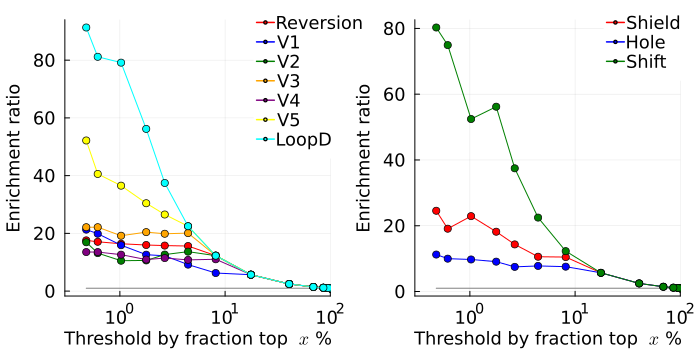

In [26]:
color_set = ["red", "blue", "green", "orange", "purple", "yellow", "cyan"]
p2 = Plots.plot(100*α_selected_est, ones(size(α_selected_est)), label=:false, c=:gray)
Plots.plot!(100*α_selected_est, x_fold_reversion_set, label="Reversion", 
    xlabel=L"Threshold by fraction top  $x$ %", 
    ylabel="Enrichment ratio", 
    c = color_set[1],
    foreground_color_legend = nothing,
    labelfontsize=12,
    legendfontsize=12, 
    m=:circle,
    tickfontsize=12,
    margin=3mm,
    xlim=(0.3,100),
    xaxis=:log,
#    xlim=(1,10),
    legend=(0.8, 0.99)
)
Plots.plot!(100*α_selected_est, x_fold_V1_set, label="V1", m=:circle, c = color_set[2],)
Plots.plot!(100*α_selected_est, x_fold_V2_set, label="V2", m=:circle, c = color_set[3],)
Plots.plot!(100*α_selected_est, x_fold_V3_set, label="V3", m=:circle, c = color_set[4],)
Plots.plot!(100*α_selected_est, x_fold_V4_set, label="V4", m=:circle, c = color_set[5],)
Plots.plot!(100*α_selected_est, x_fold_V5_set, label="V5", m=:circle, c = color_set[6],)
Plots.plot!(100*α_selected_est, x_fold_LoopD_set, label="LoopD", m=:circle, c = color_set[7],)#

p4 = Plots.plot(100*α_selected_est, ones(size(α_selected_est)), label=:false, c=:gray)
Plots.plot!(100*α_selected_est, x_fold_N_add_set, label="Shield", 
    xlabel=L"Threshold by fraction top  $x$ %", 
    ylabel="Enrichment ratio", 
    c = color_set[1],
    foreground_color_legend = nothing,
    labelfontsize=12,
    legendfontsize=12, 
    m=:circle,
    tickfontsize=12,
    margin=3mm,
    xlim=(0.3,100),
    xaxis=:log,
    legend=(0.8, 0.99)
)
Plots.plot!(100*α_selected_est, x_fold_N_rem_set, label="Hole", m=:circle, c = color_set[2],)
Plots.plot!(100*α_selected_est, x_fold_N_sht_set, label="Shift", m=:circle, c = color_set[3],)

Plots.plot(p2,p4, layout=(1,2), size=(700, 350))
#Plots.savefig("../fig/enrichment_vs_threshold_CH505.pdf")